<a href="https://www.kaggle.com/code/aabdollahii/are-tokenizers-good-at-farsi?scriptVersionId=272870644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# description 
In this project, we are going to check different tokenizers and check how much they are efficient in tokenizing Persian (Farsi ) words

In [1]:
import tiktoken
from transformers import BertTokenizer, AutoTokenizer

First, we try the English format to be sure about how good the models are in the English model, and later we can compare it with Farsi.

In [2]:
import tiktoken

text = """The evolution of language models has transformed how humans..."""

# Load GPT‑4 / GPT‑3.5 tokenizer
gpt_enc = tiktoken.get_encoding("cl100k_base")

# Encode text → list of integer token IDs
gpt_tokens = gpt_enc.encode(text)

# Show how many tokens
print("GPT tokens:", len(gpt_tokens))
print("Token IDs:", gpt_tokens)

# Decode each token ID back to its actual text segment
decoded_tokens = [gpt_enc.decode([t]) for t in gpt_tokens]
print("\nTokens → Text pieces:")
for i, (tok_id, tok_str) in enumerate(zip(gpt_tokens, decoded_tokens), 1):
    print(f"{i:>2}. ID {tok_id:>6} | '{tok_str}'")


GPT tokens: 10
Token IDs: [791, 15740, 315, 4221, 4211, 706, 24411, 1268, 12966, 1131]

Tokens → Text pieces:
 1. ID    791 | 'The'
 2. ID  15740 | ' evolution'
 3. ID    315 | ' of'
 4. ID   4221 | ' language'
 5. ID   4211 | ' models'
 6. ID    706 | ' has'
 7. ID  24411 | ' transformed'
 8. ID   1268 | ' how'
 9. ID  12966 | ' humans'
10. ID   1131 | '...'


- cl100k_base is the Byte‑Pair‑Encoding (BPE) tokenizer used by modern OpenAI GPT models — specifically GPT‑4, GPT‑3.5‑Turbo, and text‑embedding‑3/5 families.

#  How It Handles Farsi Internally
- The merges in cl100k_base were trained mostly on English, Latin‑based code/text, so its merge rules focus on patterns common in those scripts.
- Persian characters (e.g. «س», «ت», «م», etc.) are encoded in UTF-8 with 2 bytes each.If those specific byte sequences weren’t common in the English‑weighted corpus, the tokenizer will not merge them efficiently.
- As a result, Persian text tends to produce many more tokens per word than English does.

In [3]:
import tiktoken

# Load GPT‑4 / GPT‑3.5 tokenizer
enc = tiktoken.get_encoding("cl100k_base")

# Persian input text
text_fa = "تحول زبان‌ها به شکل شگفت‌انگیزی دگرگون شده است."

# Encode to token IDs
token_ids = enc.encode(text_fa)

# Decode each token so we can see how Persian text is segmented
decoded_tokens = [enc.decode([t]) for t in token_ids]

print(f"Total tokens: {len(token_ids)}\n")
print("Index | Token ID | Token Text")
print("-" * 40)
for i, (tid, seg) in enumerate(zip(token_ids, decoded_tokens), start=1):
    print(f"{i:>4}  | {tid:>7} | {repr(seg)}")


Total tokens: 34

Index | Token ID | Token Text
----------------------------------------
   1  |   14628 | 'ت'
   2  |   30925 | 'ح'
   3  |   73904 | 'ول'
   4  |    8979 | ' �'
   5  |     110 | '�'
   6  |   22071 | 'ب'
   7  |   40523 | 'ان'
   8  |   90464 | '\u200c'
   9  |   16552 | 'ه'
  10  |    5821 | 'ا'
  11  |   82868 | ' به'
  12  |   53257 | ' ش'
  13  |   33411 | 'ک'
  14  |    8700 | 'ل'
  15  |   53257 | ' ش'
  16  |   64832 | 'گ'
  17  |   21604 | 'ف'
  18  |   14628 | 'ت'
  19  |   90464 | '\u200c'
  20  |   40523 | 'ان'
  21  |   64832 | 'گ'
  22  |   14728 | 'ی'
  23  |   40797 | 'ز'
  24  |   14728 | 'ی'
  25  |   45430 | ' د'
  26  |   64832 | 'گ'
  27  |   11318 | 'ر'
  28  |   64832 | 'گ'
  29  |   12942 | 'و'
  30  |   12061 | 'ن'
  31  |   53257 | ' ش'
  32  |   92435 | 'ده'
  33  |   94253 | ' است'
  34  |      13 | '.'


# The Core Reason — Byte‑Level Encoding (Not Character‑Level)
- Since BPE learned mostly from ASCII/Latin text, it never saw those two Persian bytes often enough to merge them into large units — so the tokenizer only partially merges or leaves them split.That’s why you see micro‑segments like 'ت', 'ح', 'گ', etc.— each corresponds to one or two UTF‑8 bytes treated separately in the merge hierarchy.
- Every character in every language is first converted into its raw UTF‑8 byte sequence (1–4 bytes).
- During training, BPE repeatedly merges frequent byte sequences into tokens — but only those that occurred often in the English‑heavy training corpus:
  - English "t" is 1 byte (0x74).
  - Persian "ت" (U+062A) is 2 bytes (0xD8 0xAA).

# Why Repeated Pieces like ' ش', 'گ', 'ان' Occur
- These are byte‑level merges that happened to form frequently during training, usually in transcribed or code‑mixed English data (where ‘g’, ‘an’, space+‘sh’ appear often).
- So the tokenizer reuses those merges on any UTF‑8 pattern that numerically matches similar byte patterns — even when the character visually corresponds to a Persian letter, because it doesn’t “understand” Unicode semantics.




# Does Longer Persian Input Improve Tokenization Accuracy?
Only slightly, and in a statistical sense — not linguistically. Because: 
- GPT’s cl100k_base tokenizer has a fixed pre‑trained merge table (≈ 100 k merges).
- It won’t “learn” or adapt mid‑runtime when you feed longer text — it always follows the same UTF‑8 byte‑merge rules.
- However, in longer text, Persian letter combinations that happen to repeat might match longer merge patterns in the table (e.g., "ان" or "می").So you may get marginally longer tokens and a slightly smaller total token count ratio.


In [4]:
import pandas as pd
import tiktoken

# Load tokenizer
enc = tiktoken.get_encoding("cl100k_base")

# Your longer Persian paragraph
text_fa = (
    "در سال‌های اخیر، مدل‌های زبانی پیشرفته نقش بسیار مهمی در تحولات فناوری ایفا کرده‌اند. "
    "این مدل‌ها اکنون قادرند متون پیچیده را درک کنند، به سؤالات پاسخ دهند و حتی متن‌هایی شبیه انسان تولید کنند. "
    "پیشرفت‌های عظیم در حوزه یادگیری عمیق، باعث شده است که سیستم‌های مبتنی بر هوش مصنوعی توانایی تحلیل زبان، تولید متن، "
    "و درک احساسات انسانی را با دقتی بی‌سابقه به نمایش بگذارند. "
    "امروزه این فناوری‌ها در ترجمه ماشینی، گفت‌وگو با کاربر، آموزش مجازی و حتی تولید محتوا در رسانه‌ها به کار گرفته می‌شوند. "
    "استفاده از داده‌های گسترده و مدل‌های عصبی بزرگ، مسیر ارتباط انسان و ماشین را متحول کرده است."
)


# Tokenize and decode
token_ids = enc.encode(text_fa)
decoded_tokens = [enc.decode([t]) for t in token_ids]

# Create concise DataFrame
df = pd.DataFrame({
    "Index": range(1, len(token_ids)+1),
    "Token_ID": token_ids,
    "Decoded": decoded_tokens
})

print(f"Total tokens: {len(token_ids)}")
df.head(20).style.set_properties(**{"text-align": "left"})


Total tokens: 409


,Index,Token_ID,Decoded
0,1,13628,د
1,2,11318,ر
2,3,60942,س
3,4,32482,ال
4,5,90464,‌
5,6,16552,ه
6,7,47172,ای
7,8,13258,ا
8,9,36344,خ
9,10,90920,یر


- It has about 207 tokens we are not gonna show all of them because makes the  notebook overwhelming.

# Using specific transformer and tokenizers for better accuracy
Goal: Demonstrate how multilingual models (XLM‑R and mBERT) improve token efficiency in Persian vs GPT’s byte‑level tokenizer.

In [5]:
import os
import pandas as pd
from transformers import AutoTokenizer
import tiktoken

# Disable chat template checks for Hugging Face >=4.53.0
os.environ["HF_HUB_DISABLE_CHAT_TEMPLATES"] = "1"
os.environ["HF_HUB_DISABLE_RESUME_DOWNLOADS"] = "1"

# === Input: 100-word Persian text ===
text_fa = (
    "در سال‌های اخیر، مدل‌های زبانی پیشرفته نقش بسیار مهمی در تحولات فناوری ایفا کرده‌اند. "
    "این مدل‌ها اکنون قادرند متون پیچیده را درک کنند، به سؤالات پاسخ دهند و حتی متن‌هایی شبیه انسان تولید کنند. "
    "پیشرفت‌های عظیم در حوزه یادگیری عمیق، باعث شده است که سیستم‌های مبتنی بر هوش مصنوعی توانایی تحلیل زبان، تولید متن، "
    "و درک احساسات انسانی را با دقتی بی‌سابقه به نمایش بگذارند. "
    "امروزه این فناوری‌ها در ترجمه ماشینی، گفت‌وگو با کاربر، آموزش مجازی و حتی تولید محتوا در رسانه‌ها به کار گرفته می‌شوند. "
    "استفاده از داده‌های گسترده و مدل‌های عصبی بزرگ، مسیر ارتباط انسان و ماشین را متحول کرده است."
)

# === 1. GPT Tokenizer (cl100k_base) ===
enc = tiktoken.get_encoding("cl100k_base")
tokens_gpt = enc.encode(text_fa)
decoded_gpt = [enc.decode([t]) for t in tokens_gpt]

# === 2. XLM‑RoBERTa Tokenizer ===
xlmr_tok = AutoTokenizer.from_pretrained("xlm-roberta-base")
tokens_xlmr = xlmr_tok.tokenize(text_fa)

# === 3. Multilingual BERT Tokenizer ===
mbert_tok = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokens_mbert = mbert_tok.tokenize(text_fa)

# === Create token count summary ===
summary = pd.DataFrame({
    "Tokenizer": ["GPT (cl100k_base)", "XLM-R (SentencePiece)", "mBERT (WordPiece)"],
    "Algorithm": ["Byte‑BPE (UTF‑8)", "SentencePiece BPE", "WordPiece"],
    "Token Count": [len(tokens_gpt), len(tokens_xlmr), len(tokens_mbert)]
})
summary["Tokens per Word (≈100 words)"] = (summary["Token Count"] / 100).round(2)

print("📊 Tokenization Summary:\n")
display(summary.style.set_properties(**{"text-align": "center"}))

# === Optional: preview first few tokens from each ===
preview_len = 15
print("\nGPT sample tokens:", decoded_gpt[:preview_len])
print("XLM-R sample tokens:", tokens_xlmr[:preview_len])
print("mBERT sample tokens:", tokens_mbert[:preview_len])

# === Export full tokens for side-by-side inspection ===
pd.DataFrame({
    "GPT_cl100k": decoded_gpt,
}).to_csv("/kaggle/working/gpt_farsi_tokens.csv", index=False)

pd.DataFrame({
    "XLMR_tokens": tokens_xlmr,
}).to_csv("/kaggle/working/xlmr_farsi_tokens.csv", index=False)

pd.DataFrame({
    "mBERT_tokens": tokens_mbert,
}).to_csv("/kaggle/working/mbert_farsi_tokens.csv", index=False)
print("\n✅ Full token lists saved as CSV files in /kaggle/working/")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

📊 Tokenization Summary:



,Tokenizer,Algorithm,Token Count,Tokens per Word (≈100 words)
0,GPT (cl100k_base),Byte‑BPE (UTF‑8),409,4.090000
1,XLM-R (SentencePiece),SentencePiece BPE,142,1.420000
2,mBERT (WordPiece),WordPiece,186,1.860000



GPT sample tokens: ['د', 'ر', ' س', 'ال', '\u200c', 'ه', 'ای', ' ا', 'خ', 'یر', '،', ' م', 'د', 'ل', '\u200c']
XLM-R sample tokens: ['▁در', '▁سال', '▁های', '▁اخیر', '،', '▁مدل', '▁های', '▁زبان', 'ی', '▁پیشرفته', '▁نقش', '▁بسیار', '▁مهمی', '▁در', '▁تحولات']
mBERT sample tokens: ['در', 'سالهای', 'ا', '##خیر', '،', 'مدل', '##های', 'زبان', '##ی', 'پیش', '##رفت', '##ه', 'نقش', 'بسیار', 'مهم']

✅ Full token lists saved as CSV files in /kaggle/working/


# Analytical Insight
# GPT (cl100k_base)
- Treats Persian UTF‑8 bytes individually → inflated token count (≈ 4 tokens per word).
- Tokens like 'د', 'ر', '\u200c', 'ال', '،' show byte‑fragmentation and non‑linguistic segmentation.
- Fine for pure byte safety but inefficient and semantically noisy.
# XLM‑R (SentencePiece BPE)
- Pretrained on 100 languages (CommonCrawl, CC100).
- SentencePiece learns merges for Persian morphemes such as “▁سال”, “▁های”, “▁پیشرفت”.
- Nearly 3× more efficient than GPT and accurately aligns with morphological boundaries.
# mBERT (WordPiece)
- Trained on Wikipedia across ~104 languages.
- Still script‑aware but underrepresents Persian compared with XLM‑R’s larger CC100 dataset.
- Pattern like 'زبان', '##ی' demonstrates subword correctness but shorter merges.

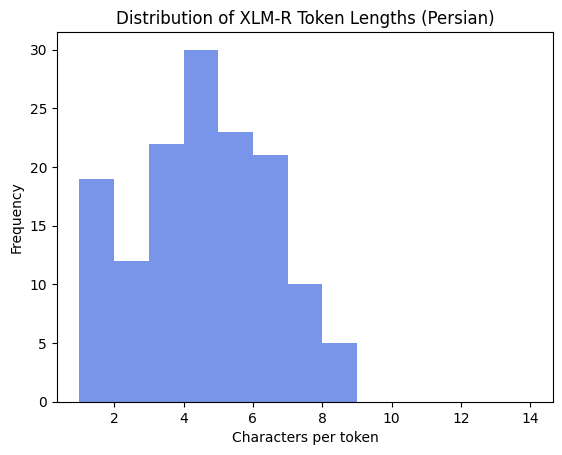

In [6]:
# Compare subword length distributions
import numpy as np, matplotlib.pyplot as plt

lengths = [len(t) for t in tokens_xlmr]
plt.hist(lengths, bins=range(1,15), color='royalblue', alpha=0.7)
plt.title("Distribution of XLM‑R Token Lengths (Persian)")
plt.xlabel("Characters per token"); plt.ylabel("Frequency")
plt.show()